# Pressure - $\eta$ transforms
Find optimal parameters for transforming Asilomar Small-Scale Array pressure measurements to sea-surface elevation $\eta$. Test both regular linear transfer function and the $\kappa_\mathrm{rms}$-based methods of Martins et al. (2021, JPO).

In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import scipy.stats as stats
from scipy import signal
from scipy.io import loadmat
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
from PyPDF2 import PdfFileMerger, PdfFileReader
# Interactive plots
%matplotlib widget 

from roxsi_pyfuns import zero_crossings as rpzc
from roxsi_pyfuns import transfer_functions as rptf
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns import plotting as rppl

# Paths
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
data_root = os.path.join(rootdir, 'Signatures', 'Level1')
bathydir = os.path.join(rootdir, 'Bathy')
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy_updated_1m.nc')
# Read bathymetry netcdf file
bathy = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))
# Output figure dir.
figdir = os.path.join(data_root, 'img', 'p2eta_opt')


Test different transfer function parameters for pressure-$\eta$ reconstruction and compare against acoustic surface track (AST) signal from Nortek Signature 1000 ADCPs around the SSA rock.

In [5]:
# New loop
mids = ['C1', 'C3', 'C6'] # Mooring IDs
sers = ['103088', '103094', '103110'] # Serial numbers
tail_method = 'constant' # K_rms reconstruction tail method
fcs = [0.25, 0.3, 0.35] # High-frequency cutoffs
prs = ['etal', 'etalk', 'etank'] # Reconstruction products
depth_strings = ['loc', 'sur'] # Depth definitions (local/surrounding)
# Time period start / end
t0 = pd.Timestamp('2022-07-13 00:00:00')
t1 = pd.Timestamp('2022-07-15 00:00:00')
# Make date array
date_range = pd.date_range(t0, t1, freq='1D')

# Read L5 spectral file for surrounding depth
fn_l5 = os.path.join(data_root, '103206', 'Spectra', 
    'Asilomar_2022_SSA_Signature_103206_spec_AST.nc')
dsl5 = xr.decode_cf(xr.open_dataset(fn_l5, decode_coords='all'))

# Concatenate datasets
dsd = {} # Dict for concatenated datasets
print('Concatenating datasets ...')
for mid, ser in zip([mids[1]], [sers[1]]):
    print('{} {}'.format(mid, ser))
    # Iterate over dates and concatenate datasets
    dsl = [] # List for concatenating daily datasets
    for date in date_range:
        # Signature velocity netcdf directory
        veldir = os.path.join(data_root, '{}'.format(ser)) 
        # List netcdf files in veldir
        fns_v = sorted(glob.glob(os.path.join(veldir, 'Asilomar_*.nc')))
        datestr = '{}{:02d}{:02d}'.format(date.year, date.month, date.day)
        fn_sig = [f for f in fns_v if datestr in f]
        # Read netcdf file w/ AST and pressure
        dsv = xr.open_dataset(fn_sig[0], decode_coords='all')
        # Only save pressure and AST
        dsv = dsv[['pressure', 'ASTd', 'z_hyd']]
        # Append to list
        dsl.append(dsv)
    # Concatenate daily datasets
    dsd[mid] = xr.concat(dsl, dim='time')

print('Transforming p -> eta ...')
# Make segment time array
seg_range = pd.date_range(t0 + pd.Timedelta(hours=1), t1 - pd.Timedelta(hours=1), freq='20T')
# Concatenated dataframes dict
dfc = {}
# Iterate over instruments + segments and convert pressure to surface elevation
for mid, ser in zip([mids[1]], [sers[1]]):
    print(mid)
    # Signature velocity netcdf directory
    veldir = os.path.join(data_root, '{}'.format(ser)) 
    # Check if output csv file exists
    csvdir = os.path.join(veldir, 'p2eta')
    # Check if directory exists; if not, make dir
    if not os.path.isdir(csvdir):
        os.mkdir(csvdir)
    # Append segment dataframes to list and concatenate after
    dflist = []
    # Iterate over 20-min. segments
    for t0s in seg_range:
        # Compute index (from start of date)
        si = int((t0s - t0s.floor('1D')) / pd.Timedelta(minutes=20))
        # Check if dataframe already saved
        fn_dfe = os.path.join(csvdir, 'p2eta_{}_{}{:02d}{:02d}_{:02d}.csv'.format(
            mid, t0s.year, t0s.month, t0s.day, si))
        if not os.path.isfile(fn_dfe):
            # Segment end
            t1s = t0s + pd.Timedelta(minutes=20)
            seg = dsd[mid].sel(time=slice(t0s, t1s)).copy()
            # Use AST and pressure for spectra
            z_ast = seg.ASTd.values
            eta_ast = z_ast - np.mean(z_ast) # AST
            z_hyd = seg.z_hyd.values # hydrostatic pressure head
            eta_hyd = z_hyd - np.mean(z_hyd) # hydrostatic surface
            time_index = seg.time.values # Time index for dataframe

            # Save eta products to dataframe
            dfe = pd.DataFrame(data={'eta_hyd': eta_hyd, 'eta_ast': eta_ast},
                               index=time_index)
            dfe.index = dfe.index.rename('time')
            # Depth definition: local/surrounding/surrounding only for k
            for d_str in ['loc', 'sur', 'sur_k']:
                # Define depth
                depth_loc = np.mean(z_ast) + 0.33 # local depth
                depth_L5 = dsl5.depth_loc.sel(time=t0s.round('1H')).item() 
                msl_L5 = bathy.L5.item() # MSL at L5
                msl_dev = depth_L5 - np.abs(msl_L5)
                # Average surrounding msl (negative)
                msl_sur = bathy.sel(x=slice(bathy.C1.x_loc, bathy.C6.x_loc), 
                    y=slice(bathy.L1.y_loc, bathy.L5.y_loc)).z_msl.mean().item()
                # Average surrounding depth
                depth_sur = np.abs(msl_sur) + msl_dev
                if d_str == 'loc':
                    # Use local depth for calculations
                    depth = np.mean(z_ast) + 0.33
                    depth_dev = 0 # Deviation from local depth
                    depth_k = None # Don't assume specific depth for wavenumbers
                elif d_str == 'sur':
                    depth = depth_sur
                    depth_dev = depth_sur - depth_loc # Deviation from local depth
                    depth_k = None # Don't assume specific depth for wavenumbers
                elif d_str == 'sur_k':
                    # Local depth for all but wavenumbers, which use surrounding depth
                    depth = np.mean(z_ast) + 0.33
                    depth_dev = 0 # Deviation from local depth
                    depth_k = depth_sur 
                # Initialize TRF object
                trf = rptf.TRF(fs=4, zp=0.33+depth_dev)
                # Compute bispectrum and use it to get K_rms
                if depth_k is not None:
                    dsb = rpws.bispectrum(eta_hyd, fs=4, h0=depth_k, return_krms=True)
                else:
                    dsb = rpws.bispectrum(eta_hyd, fs=4, h0=depth, return_krms=True)
                krms = dsb.k_rms.values
                f_krms = dsb.freq1.values
                # Test varying max. cutoff frequencies
                for fc in fcs:
                    # Regular linear reconstruction (returns depth)
                    z_lin = trf.p2z_lin(z_hyd, fmax=fc, depth_dev=depth_dev, depth_k=depth_k)
                    eta_lin = z_lin - np.mean(z_lin)
                    # Compute spectrum from eta_lin
                    dss = rpws.spec_uvz(eta_lin, fs=4)
                    # (Non)linear K_rms reconstructions assuming
                    eta_lin_krms, eta_nl_krms = trf.p2eta_krms(eta_hyd, h0=depth, fc=fc, 
                        fcmax_allowed=fc, f_krms=f_krms, krms=krms, return_nl=True, fmax=1, 
                        fp=(1 / dss.Tp_Y95.item()), fix_ends=False, tail_method=tail_method,
                        depth_k=depth_k, depth_dev=depth_dev)
                    # Fix end points with overlapping reconstructions
                    t0ob = t0s - pd.Timedelta(minutes=10) # half period before t0
                    t1ob = t0s + pd.Timedelta(minutes=10) # half period before t1
                    # Get hydrostatic signal 
                    seg0 = dsd[mid].sel(time=slice(t0ob, t1ob)).copy() # Overlap segment slice
                    times0 = seg0.time.values
                    z_hyd0 = seg0.z_hyd.values
                    eta_hyd0 = z_hyd0 - np.mean(z_hyd0)

                    # Reconstruct linear
                    z_lin0 = trf.p2z_lin(z_hyd0, fmax=fc, depth_dev=depth_dev, depth_k=depth_k)
                    eta_lin0 = z_lin0 - np.mean(z_lin0)
                    # Reconstruct (non)linear K_rms
                    eta_lin_krms0, eta_nl_krms0 = trf.p2eta_krms(eta_hyd0, h0=depth, fc=fc, 
                        fcmax_allowed=fc, f_krms=f_krms, krms=krms, return_nl=True, fmax=1, 
                        fp=(1 / dss.Tp_Y95.item()), fix_ends=False, tail_method=tail_method,
                        depth_k=depth_k, depth_dev=depth_dev)
                    # Also get half period after
                    t0oa = t1s - pd.Timedelta(minutes=10) # half period before t0
                    t1oa = t1s + pd.Timedelta(minutes=10) # half period before t1
                    # Get hydrostatic signal 
                    seg1 = dsd[mid].sel(time=slice(t0oa, t1oa)).copy() # Overlap segment slice
                    times1 = seg1.time.values
                    z_hyd1 = seg1.z_hyd.values
                    eta_hyd1 = z_hyd1 - np.mean(z_hyd1)
                    # Reconstruct linear
                    z_lin1 = trf.p2z_lin(z_hyd1, fmax=fc, depth_dev=depth_dev, depth_k=depth_k)
                    eta_lin1 = z_lin1 - np.mean(z_lin1)
                    # Reconstruct (non)linear K_rms
                    eta_lin_krms1, eta_nl_krms1 = trf.p2eta_krms(eta_hyd1, h0=depth, fc=fc, 
                        fcmax_allowed=fc, f_krms=f_krms, krms=krms, return_nl=True, fmax=1, 
                        fp=(1 / dss.Tp_Y95.item()), fix_ends=False, tail_method=tail_method,
                        depth_k=depth_k, depth_dev=depth_dev)
                    # Make dataframes and merge end points
                    dfm0 = pd.DataFrame(data={'eta_lin': eta_lin0, 
                                              'eta_lin_krms':eta_lin_krms0, 
                                              'eta_nl_krms':eta_nl_krms0, 
                                              },
                                        index=times0)
                    dfm0.index = dfm0.index.rename('time')
                    dfm = pd.DataFrame(data={'eta_lin': eta_lin, 
                                             'eta_lin_krms':eta_lin_krms, 
                                             'eta_nl_krms':eta_nl_krms, 
                                             },
                                        index=time_index)
                    dfm.index = dfm.index.rename('time')
                    dfm1 = pd.DataFrame(data={'eta_lin': eta_lin1, 
                                              'eta_lin_krms':eta_lin_krms1, 
                                              'eta_nl_krms':eta_nl_krms1, 
                                              },
                                        index=times1)
                    dfm1.index = dfm1.index.rename('time')
                    # Merge left and right dataframes with original (middle)
                    dfl = dfm.join(dfm0, on='time', how='left', lsuffix='_o', rsuffix='_l')
                    dfr = dfm.join(dfm1, on='time', how='left', lsuffix='_o', rsuffix='_r')
                    # Use first 100 samples from left dataframe to fix start edge effects
                    eta_lin_m = np.concatenate((dfl['eta_lin_l'].iloc[:100], 
                                                dfl['eta_lin_o'].iloc[100:]))
                    eta_lin_krms_m = np.concatenate((dfl['eta_lin_krms_l'].iloc[:100], 
                                                    dfl['eta_lin_krms_o'].iloc[100:]))
                    eta_nl_krms_m = np.concatenate((dfl['eta_nl_krms_l'].iloc[:100], 
                                                    dfl['eta_nl_krms_o'].iloc[100:]))
                    # Use last 100 samples from right dataframe to fix end edge effects
                    eta_lin_m = np.concatenate((eta_lin_m[:-100], dfr['eta_lin_r'].iloc[-100:]))
                    eta_lin_krms_m = np.concatenate((eta_lin_krms_m[:-100], 
                                                    dfr['eta_lin_krms_r'].iloc[-100:]))
                    eta_nl_krms_m = np.concatenate((eta_nl_krms_m[:-100], 
                                                    dfr['eta_nl_krms_r'].iloc[-100:]))
                    # Save variables to combined dataframe
                    dfe['eta_lin_fc_{}_d_{}'.format(fc, d_str)] = eta_lin_m
                    dfe['eta_lin_krms_fc_{}_d_{}'.format(fc, d_str)] = eta_lin_krms_m
                    dfe['eta_nl_krms_fc_{}_d_{}'.format(fc, d_str)] = eta_nl_krms_m
            # Save dfe to file
            dfe.to_csv(fn_dfe)
            # Append to list for concatenating
            dflist.append(dfe)
        else:
            # Read existing dfe
            dfe = pd.read_csv(fn_dfe, parse_dates=['time']).set_index('time')
            # Append to list for concatenating
            dflist.append(dfe)

    # Concatenate dataframes
    dfc['{}'.format(mid)] = pd.concat(dflist)

# Make plots of spectra
print('Plotting spectra ...')
lss = ['-', '--', ':'] # Linestyles for different cutoff freqs
cls = ['#FE4A49', '#009FB7', '#FED766']
# Latest segment start time
t0_max = pd.Timestamp('2022-07-14 11:00')
# Concatenated spectral ratios dicts
sde_c = {}
sdek_c = {}
sdenk_c = {}

# Iterate over instruments + segments and estimate spectra and plot
for mid, ser in zip([mids[1]], [sers[1]]):
    # Define output figure directory for current mooring ID
    figdir_mid = os.path.join(figdir, mid)
    if not os.path.isdir(figdir_mid):
        os.mkdir(figdir_mid)
    figdir_spec = os.path.join(figdir_mid, 'spec')
    if not os.path.isdir(figdir_spec):
        os.mkdir(figdir_spec)
    # Spectral ratios figure filename
    fn_ratios = os.path.join(figdir_mid, 'ezz_ratios_{}.pdf'.format(mid))
    # Save spectral ratios vs. AST in lists for averaging
    dss = ['loc', 'sur', 'sur_k']
    sde = {'eta_l_{}_{}'.format(f,d):[] for f in fcs for d in dss} 
    sdek = {'eta_lk_{}_{}'.format(f,d):[] for f in fcs for d in dss} 
    sdenk = {'eta_nk_{}_{}'.format(f,d):[] for f in fcs for d in dss} 
    # Iterate over 20-min. segments
    for t0s in seg_range:
        # Segment end
        t1s = t0s + pd.Timedelta(minutes=20)
        # Stop if going beyond t0_max
#         if t0s > t0_max:
#             continue
        # Compute index (from start of date)
        si = int((t0s - t0s.floor('1D')) / pd.Timedelta(minutes=20))
        # Check if figure already saved
        fn_fig = os.path.join(figdir_spec, 'p2eta_spec_{}_{}{:02d}{:02d}_{:02d}.pdf'.format(
            mid, t0s.year, t0s.month, t0s.day, si))
        if not os.path.isfile(fn_fig):
            # Take out segment from dict
            seg = dfc[mid].loc[t0s:t1s].copy()
            depth_L5 = dsl5.depth_loc.sel(time=t0s.round('1H')).item() 
            msl_L5 = bathy.L5.item() # MSL at L5
            # msl_dev = depth_L5 - np.abs(msl_L5)
            # Average surrounding msl (negative)
            msl_sur = bathy.sel(x=slice(bathy.C1.x_loc, bathy.C6.x_loc), 
                y=slice(bathy.L1.y_loc, bathy.L5.y_loc)).z_msl.mean().item()
            # Average surrounding depth
            msl_dev = dsl5.msl_dev.sel(time=t0s.floor('1H')).item()
            depth_sur = np.abs(msl_sur) + msl_dev
#             # Get depths
#             depth_sur = dsl5.depth_loc.sel(time=t0s.floor('1H')).item() # L5 depth
            msl_loc = np.abs(bathy[mid].item())
            depth_loc = msl_loc + msl_dev # Local depth
            # Initialize figure
            fig, axes = plt.subplots(figsize=(11,6), ncols=3, nrows=2, sharex=True, 
                sharey='row', gridspec_kw={'height_ratios':[2,1]})
            # Estimate spectra
            dsa = rpws.spec_uvz(seg['eta_ast'].values, fs=4) # AST spectrum
            for di,d_str in enumerate(['loc', 'sur', 'sur_k']):
                for fi,fc in enumerate(fcs):
                    # Take out surface elevations
                    etal = seg['eta_lin_fc_{}_d_{}'.format(fc, d_str)].values
                    etalk = seg['eta_lin_krms_fc_{}_d_{}'.format(fc, d_str)].values
                    etanlk = seg['eta_nl_krms_fc_{}_d_{}'.format(fc, d_str)].values
                    # Estimate spectra
                    dse = rpws.spec_uvz(etal, fs=4)
                    dsek = rpws.spec_uvz(etalk, fs=4)
                    dsenk = rpws.spec_uvz(etanlk, fs=4)
                    # Plot spectra on top row
                    dse.Ezz.plot(ax=axes[0,di], linestyle=lss[fi], color=cls[0],
                        label=r'$\eta_\mathrm{l}$'+' fc={}Hz'.format(fc))
                    dsek.Ezz.plot(ax=axes[0,di], linestyle=lss[fi], color=cls[1],
                        label=r'$\eta_\mathrm{l,K}$'+' fc={}Hz'.format(fc))
                    dsenk.Ezz.plot(ax=axes[0,di], linestyle=lss[fi], color=cls[2],
                        label=r'$\eta_\mathrm{nl,K}$'+' fc={}Hz'.format(fc))
                    # Plot ratios of spectra against AST on bottom row
                    elr = (dse.Ezz / dsa.Ezz).to_dataframe(name=si)
                    elr.plot(ax=axes[1,di], linestyle=lss[fi], color=cls[0], legend=None)
                    elkr = (dsek.Ezz / dsa.Ezz).to_dataframe(name=si)
                    elkr.plot(ax=axes[1,di], linestyle=lss[fi], color=cls[1], legend=None)
                    enkr = (dsenk.Ezz / dsa.Ezz).to_dataframe(name=si)
                    enkr.plot(ax=axes[1,di], linestyle=lss[fi], color=cls[2], legend=None)
                    # Save Ezz ratios in dataframes for averaging
                    sde['eta_l_{}_{}'.format(fc,d_str)].append(elr)
                    sdek['eta_lk_{}_{}'.format(fc,d_str)].append(elkr)
                    sdenk['eta_nk_{}_{}'.format(fc,d_str)].append(enkr)

            # Plot AST spectrum on top
            dsa.Ezz.plot(ax=axes[0,0], color='k', label='AST')
            dsa.Ezz.plot(ax=axes[0,1], color='k', label='AST')
            dsa.Ezz.plot(ax=axes[0,2], color='k', label='AST')

            axes[0,0].legend(fontsize=8, ncols=2)
            for ax in axes[0,:]:
                ax.set_xlabel(None)
                ax.set_ylabel(None)
                # Log scale
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.set_ylim([1e-4, 10])
                ax.set_xlim([0.05, 0.35])
                ax.grid(alpha=0.5)
            for ax in axes[1,:]:
                ax.set_xlabel('Frequency [Hz]')
                ax.set_ylabel(None)
                ax.set_xscale('log')
                # ax.set_yscale('log')
                ax.set_ylim([0.0, 2.0])
                ax.set_xlim([0.05, 0.35])
                ax.grid(alpha=0.5)
            axes[0,0].set_title('Local depth = {:.2f}m'.format(depth_loc))
            axes[0,1].set_title('Surrounding depth = {:.2f}m'.format(depth_sur))
            axes[0,2].set_title(r'Surrounding depth for $k$ only')
            axes[0,0].set_ylabel(r'$E_{zz} \, \, \mathrm{[m^2/Hz]}$')
            axes[1,0].set_ylabel(r'$E_{zz}$ ratio vs. AST [-]')

            plt.suptitle('{} {}-{}'.format(mid, t0s, t1s.time()))
            plt.tight_layout()
            plt.savefig(fn_fig, bbox_inches='tight', dpi=300)
            plt.close()
        else:
            # Check if mean ratios figure saved
            if not os.path.isfile(fn_ratios):
                # Take out segment from dict
                seg = dfc[mid].loc[t0s:t1s].copy()
                # Only compute spectral ratios, don't plot
                dsa = rpws.spec_uvz(seg['eta_ast'].values, fs=4) # AST spectrum
                for di,d_str in enumerate(['loc', 'sur', 'sur_k']):
                    for fi,fc in enumerate(fcs):
                        # Take out surface elevations
                        etal = seg['eta_lin_fc_{}_d_{}'.format(fc, d_str)].values
                        etalk = seg['eta_lin_krms_fc_{}_d_{}'.format(fc, d_str)].values
                        etanlk = seg['eta_nl_krms_fc_{}_d_{}'.format(fc, d_str)].values
                        # Estimate spectra
                        dse = rpws.spec_uvz(etal, fs=4)
                        dsek = rpws.spec_uvz(etalk, fs=4)
                        dsenk = rpws.spec_uvz(etanlk, fs=4)
                        # Compute ratios vs AST
                        elr = (dse.Ezz / dsa.Ezz).to_dataframe(name=si)
                        elkr = (dsek.Ezz / dsa.Ezz).to_dataframe(name=si)
                        enkr = (dsenk.Ezz / dsa.Ezz).to_dataframe(name=si)
                        # Save Ezz ratios in dataframes for averaging
                        sde['eta_l_{}_{}'.format(fc,d_str)].append(elr)
                        sdek['eta_lk_{}_{}'.format(fc,d_str)].append(elkr)
                        sdenk['eta_nk_{}_{}'.format(fc,d_str)].append(enkr)
    
    # Concatenate ratios and plot means
    if not os.path.isfile(fn_ratios):
        fig, axes = plt.subplots(figsize=(10,3), ncols=3, sharex=True, sharey=True)
        for fi,fc in enumerate(fcs):
            for di,d_str in enumerate(['loc', 'sur', 'sur_k']):
                # Eta lin
                sde_c['eta_l_{}_{}'.format(fc,d_str)] = pd.concat(
                    sde['eta_l_{}_{}'.format(fc,d_str)], axis=1)
                # Plot mean ratio
                sde_c['eta_l_{}_{}'.format(fc,d_str)].mean(axis=1).plot(
                    ax=axes[di], linestyle=lss[fi], color=cls[0],
                    label=r'$\eta_\mathrm{l}$'+' fc={}Hz'.format(fc))
                # Eta lin-krms
                sdek_c['eta_lk_{}_{}'.format(fc,d_str)] = pd.concat(
                    sdek['eta_lk_{}_{}'.format(fc,d_str)], axis=1)
                # Plot mean ratio
                sdek_c['eta_lk_{}_{}'.format(fc,d_str)].mean(axis=1).plot(
                    ax=axes[di], linestyle=lss[fi], color=cls[1],
                    label=r'$\eta_\mathrm{l,K}$'+' fc={}Hz'.format(fc))
                # Eta nonlin-krms
                sdenk_c['eta_nk_{}_{}'.format(fc,d_str)] = pd.concat(
                    sdenk['eta_nk_{}_{}'.format(fc,d_str)], axis=1)
                # Plot mean ratio
                sdenk_c['eta_nk_{}_{}'.format(fc,d_str)].mean(axis=1).plot(
                    ax=axes[di], linestyle=lss[fi], color=cls[2],
                    label=r'$\eta_\mathrm{nl,K}$'+' fc={}Hz'.format(fc))
        axes[0].legend(ncols=2, fontsize=6)
        axes[0].set_ylabel(r'$E_{zz}$ ratio vs. AST')
        axes[0].set_title('Local depth at {}'.format(mid))
        axes[1].set_title('Surrounding depth')
        axes[2].set_title(r'Surr. depth for $k$ only')
        for ax in axes:
            ax.grid(alpha=0.5)
            ax.set_xlim([0.05, 0.35])
            ax.set_ylim([0.2, 1.8])
            ax.set_xlabel('Frequency [Hz]')
        plt.tight_layout()
        plt.savefig(fn_ratios, bbox_inches='tight', dpi=300)
        plt.close()



Concatenating datasets ...
C1 103088
Transforming p -> eta ...
C1
Plotting spectra ...


Plot wavenumbers vs. frequencies

In [6]:
# Plot individual wave height scatter plots
print('Estimating zero-crossing wave/crest heights ...')
lss = ['-', '--', ':'] # Linestyles for different cutoff freqs
cls = ['#FE4A49', '#009FB7', '#FED766']
dss = ['loc', 'sur', 'sur_k']
# Latest segment start time
t0_max = pd.Timestamp('2022-07-14 11:00')
# Iterate over instruments + segments and estimate spectra and plot
for mid, ser in zip([mids[0]], [sers[0]]):
    # Define output figure directory for current mooring ID
    figdir_mid = os.path.join(figdir, mid)
    if not os.path.isdir(figdir_mid):
        os.mkdir(figdir_mid)
    figdir_zc = os.path.join(figdir_mid, 'zero_crossings')
    if not os.path.isdir(figdir_zc):
        os.mkdir(figdir_zc)

    # Initialize dicts for wave and crest heights
    Hws_l = {'H-{}-{}'.format(f, d): [] for f in fcs for d in dss}
    Hws_lk = {'H-{}-{}'.format(f, d): [] for f in fcs for d in dss}
    Hws_nk = {'H-{}-{}'.format(f, d): [] for f in fcs for d in dss}
    Hcs_l = {'C-{}-{}'.format(f, d): [] for f in fcs for d in dss}
    Hcs_lk = {'C-{}-{}'.format(f, d): [] for f in fcs for d in dss}
    Hcs_nk = {'C-{}-{}'.format(f, d): [] for f in fcs for d in dss}
    # Add ast
    Hws_l['H-ast'] = []
    Hws_lk['H-ast'] = []
    Hws_nk['H-ast'] = []
    Hcs_l['C-ast'] = []
    Hcs_lk['C-ast'] = []
    Hcs_nk['C-ast'] = []
    timestamps = [] # List to store timestamps for dataframe index
    # Iterate over 20-min. segments
    for t0s in seg_range:
        # Segment end
        t1s = t0s + pd.Timedelta(minutes=20)
        # Stop if going beyond t0_max
#         if t0s > t0_max:
#             continue
        # Compute index (from start of date)
        si = int((t0s - t0s.floor('1D')) / pd.Timedelta(minutes=20))
        # Take out segment from dict
        seg = dfc[mid].loc[t0s:t1s].copy()
        # Take out hydrostatic surface elevation
        etah = seg['eta_hyd'].values
        # Use hydrostatic zero-crossings in all cases
        zc, Hwh, Hch, Hth = rpzc.get_waveheights(etah, method='up', minlen=3*4)
        # Get AST wave/crest heights
        eta_ast = seg['eta_ast'].values
        _, Hwa, Hca, Hta = rpzc.get_waveheights(eta_ast, zero_crossings=zc)
        Hws_l['H-ast'].extend(Hwa)
        Hcs_l['C-ast'].extend(Hca)
        for di,d_str in enumerate(['loc', 'sur', 'sur_k']):
            for fi,fc in enumerate(fcs):
                # Take out surface elevations
                etal = seg['eta_lin_fc_{}_d_{}'.format(fc, d_str)].values
                etalk = seg['eta_lin_krms_fc_{}_d_{}'.format(fc, d_str)].values
                etanlk = seg['eta_nl_krms_fc_{}_d_{}'.format(fc, d_str)].values
                # Get individual wave/crest heights (min. 3-sec waves)
                _, Hwe, Hce, Hte = rpzc.get_waveheights(etal, zero_crossings=zc)
                _, Hwek, Hcek, Htek = rpzc.get_waveheights(etalk, zero_crossings=zc)
                _, Hwenk, Hcenk, Htenk = rpzc.get_waveheights(etanlk, zero_crossings=zc)
                Hws_l['H-{}-{}'.format(fc, d_str)].extend(Hwe)
                Hws_lk['H-{}-{}'.format(fc, d_str)].extend(Hwek)
                Hws_nk['H-{}-{}'.format(fc, d_str)].extend(Hwenk)
                # Crest heights
                Hcs_l['C-{}-{}'.format(fc, d_str)].extend(Hce)
                Hcs_lk['C-{}-{}'.format(fc, d_str)].extend(Hcek)
                Hcs_nk['C-{}-{}'.format(fc, d_str)].extend(Hcenk)
                timestamps.extend(seg.index[zc[:-1]])

    fc = 0.35 # Cutoff freq. to plot
    # Check if figures already saved
    fn_fig_hw = os.path.join(figdir_zc, 'p2eta_zc_hw_{}_fc_{}cHz.pdf'.format(mid, 
        int(fc*100)))
    fn_fig_hc = os.path.join(figdir_zc, 'p2eta_zc_hc_{}_fc_{}cHz.pdf'.format(mid,
        int(fc*100)))
    if not os.path.isfile(fn_fig_hw) or not os.path.isfile(fn_fig_hc):
        # Plot
        print('Plotting zero-crossing wave/crest heights ...')
        fig, axes = plt.subplots(figsize=(7,7), nrows=3, ncols=3, sharex=True,
                                 sharey=True)
        # List to store images for colorbar
        ims = []
        for di,d_str in enumerate(['loc', 'sur', 'sur_k']):
            y = np.array(Hcs_l['C-ast']) # AST always on y axis
            for i in range(3):
                if i == 0:
                    # Linear reconstruction on x axis
                    x = np.array(Hcs_l['C-{}-{}'.format(fc, d_str)])
                elif i == 1:
                    # Linear Krms reconstruction on x axis
                    x = np.array(Hcs_lk['C-{}-{}'.format(fc, d_str)])
                elif i == 2:
                    # Nonlinear Krms reconstruction on x axis
                    x = np.array(Hcs_nk['C-{}-{}'.format(fc, d_str)])
                # axes[0,di].scatter(x, y, s=2, alpha=0.3, c='k')
                # Use 2D histogram for scatter plot
                _, _, _, im = axes[i,di].hist2d(x, y, norm=colors.LogNorm(), 
                    cmap=mpl.cm.gray, bins=[50,50])
                # Save image to list
                ims.append(im)
                # Quantile-quantile plot
                rppl.qqplot(x, y, ax=axes[i,di], scatter=False, color='r')
                # Linear regression
                res = linregress(x, y)
                rmse = mean_squared_error(x, y, squared=False)
                # xp = np.linspace(0, x.max())
                xp = np.linspace(0, 3)
                # Linear regression line
                axes[i,di].plot(xp, res.intercept + res.slope*xp, color='k', 
                    linewidth=1)
                # One-to-one line
                axes[i,di].plot(xp, xp, color='k', linestyle='--')
                # Annotate regression statistics
                rsq = r'$R^2$={:.2f}'.format(res.rvalue**2)
                fsz = 7
                axes[i,di].annotate(rsq, xy=(0.57, 0.18), xycoords="axes fraction", 
                    fontsize=fsz)
                rmsestr = 'RMSE={:.2f}'.format(rmse)
                axes[i,di].annotate(rmsestr, xy=(0.57, 0.1), xycoords="axes fraction", 
                    fontsize=fsz)
                bias = 'Bias={:.2f}'.format(res.slope - 1)
                axes[i,di].annotate(bias, xy=(0.57, 0.02), xycoords="axes fraction", 
                    fontsize=fsz)
                # Also annotate cutoff frequency
                axes[i,di].annotate(r'$f_\mathrm{c}$='+'{:.2f} Hz'.format(fc), 
                    xy=(0.05, 0.9), xycoords="axes fraction", fontsize=fsz+1)
        # Colorbar on upper left subplot
        cax = axes[0,2].inset_axes([1.04, 0, 0.05, 1.00], 
            transform=axes[0,2].transAxes)
        cbar = fig.colorbar(ims[2], ax=axes[0,2], cax=cax, orientation='vertical')
        # cax.xaxis.set_ticks_position('top')
        # Labels
        axes[0,0].set_ylabel(r'$H_\mathrm{c}$ (AST) [m]', fontsize=10)
        axes[1,0].set_ylabel(r'$H_\mathrm{c}$ (AST) [m]', fontsize=10)
        axes[2,0].set_ylabel(r'$H_\mathrm{c}$ (AST) [m]', fontsize=10)
        titles = ['Local depth at {}'.format(mid), 'Surrounding depth',
                  r'Surr. depth for $k$ only']
        for ai,ax in enumerate(axes[0,:]):
            ax.set_title(titles[ai])
            ax.set_xlabel(r'$H_\mathrm{c}$ (linear) [m]', fontsize=10)
        for ax in axes[1,:]:
            ax.set_xlabel(r'$H_\mathrm{c}$ (linear, $K_\mathrm{rms}$) [m]', 
                fontsize=10)
        for ax in axes[2,:]:
            ax.set_xlabel(r'$H_\mathrm{c}$ (nonlin., $K_\mathrm{rms}$) [m]', 
                fontsize=10)
        for ax in axes.flat:
            ax.set_xlim([0, 3])
            ax.set_ylim([0, 3])
            ax.set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
            ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
        
        plt.tight_layout()
        # plt.show()
        plt.savefig(fn_fig_hc, bbox_inches='tight', dpi=300)
        plt.close()




Estimating zero-crossing wave/crest heights ...
Plotting zero-crossing wave/crest heights ...


Estimating significant wave heights ...
Plotting zero-crossing wave/crest heights ...


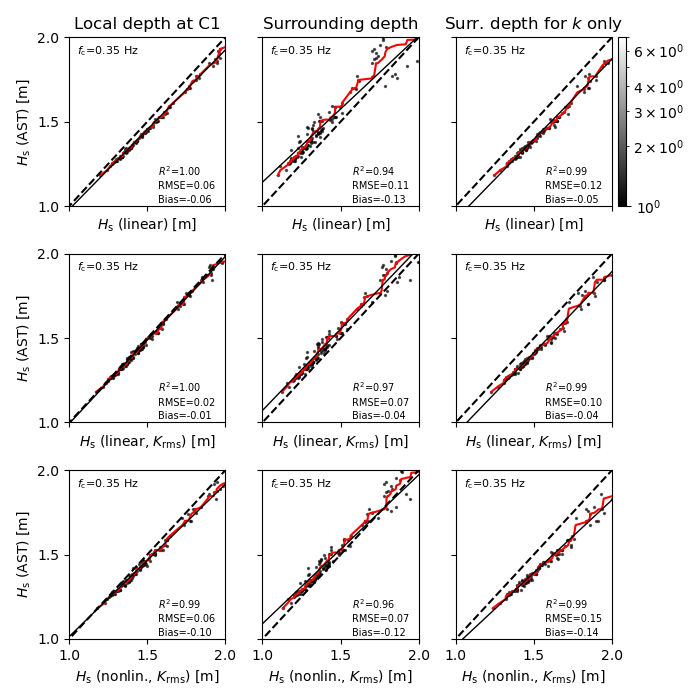

In [14]:
# Plot significant wave height scatter plots
print('Estimating significant wave heights ...')
lss = ['-', '--', ':'] # Linestyles for different cutoff freqs
cls = ['#FE4A49', '#009FB7', '#FED766']
dss = ['loc', 'sur', 'sur_k']
# Latest segment start time
t0_max = pd.Timestamp('2022-07-14 11:00')
# Iterate over instruments + segments and estimate spectra and plot
for mid, ser in zip([mids[0]], [sers[0]]):
    # Define output figure directory for current mooring ID
    figdir_mid = os.path.join(figdir, mid)
    if not os.path.isdir(figdir_mid):
        os.mkdir(figdir_mid)
    figdir_hs = os.path.join(figdir_mid, 'bulk_waveheights')
    if not os.path.isdir(figdir_hs):
        os.mkdir(figdir_hs)

    # Initialize dicts for wave and crest heights
    Hs_l = {'H-{}-{}'.format(f, d): [] for f in fcs for d in dss}
    Hs_lk = {'H-{}-{}'.format(f, d): [] for f in fcs for d in dss}
    Hs_nk = {'H-{}-{}'.format(f, d): [] for f in fcs for d in dss}
    # Add ast
    Hs_l['H-ast'] = []
    Hs_lk['H-ast'] = []
    Hs_nk['H-ast'] = []
    timestamps = [] # List to store timestamps for dataframe index
    # Iterate over 20-min. segments
    for t0s in seg_range:
        # Segment end
        t1s = t0s + pd.Timedelta(minutes=20)
        # Stop if going beyond t0_max
#         if t0s > t0_max:
#             continue
        # Compute index (from start of date)
        si = int((t0s - t0s.floor('1D')) / pd.Timedelta(minutes=20))
        # Take out segment from dict
        seg = dfc[mid].loc[t0s:t1s].copy()
        # Take out hydrostatic surface elevation
        etah = seg['eta_hyd'].values
        # Get AST Hs
        eta_ast = seg['eta_ast'].values
        spec_ast = rpws.spec_uvz(eta_ast, fs=4)
        Hsa = spec_ast.Hm0.item()
        Hs_l['H-ast'].append(Hsa)
        for di,d_str in enumerate(['loc', 'sur', 'sur_k']):
            for fi,fc in enumerate(fcs):
                # Take out surface elevations
                etal = seg['eta_lin_fc_{}_d_{}'.format(fc, d_str)].values
                etalk = seg['eta_lin_krms_fc_{}_d_{}'.format(fc, d_str)].values
                etanlk = seg['eta_nl_krms_fc_{}_d_{}'.format(fc, d_str)].values
                # Get spectra
                spec_l = rpws.spec_uvz(etal, fs=4)
                Hse = spec_l.Hm0.item()
                spec_lk = rpws.spec_uvz(etalk, fs=4)
                Hsek = spec_lk.Hm0.item()
                spec_nk = rpws.spec_uvz(etanlk, fs=4)
                Hsenk = spec_nk.Hm0.item()
                # Append
                Hs_l['H-{}-{}'.format(fc, d_str)].append(Hse)
                Hs_lk['H-{}-{}'.format(fc, d_str)].append(Hsek)
                Hs_nk['H-{}-{}'.format(fc, d_str)].append(Hsenk)
                timestamps.extend(seg.index[zc[:-1]])

    fc = 0.35 # Cutoff freq. to plot
    # Check if figures already saved
    fn_fig_hs = os.path.join(figdir_hs, 'p2eta_hs_{}_fc_{}cHz.pdf'.format(mid, 
        int(fc*100)))
    if not os.path.isfile(fn_fig_hs):
        # Plot
        print('Plotting zero-crossing wave/crest heights ...')
        fig, axes = plt.subplots(figsize=(7,7), nrows=3, ncols=3, sharex=True,
                                 sharey=True)
        # List to store images for colorbar
        ims = []
        for di,d_str in enumerate(['loc', 'sur', 'sur_k']):
            y = np.array(Hs_l['H-ast']) # AST always on y axis
            for i in range(3):
                if i == 0:
                    # Linear reconstruction on x axis
                    x = np.array(Hs_l['H-{}-{}'.format(fc, d_str)])
                elif i == 1:
                    # Linear Krms reconstruction on x axis
                    x = np.array(Hs_lk['H-{}-{}'.format(fc, d_str)])
                elif i == 2:
                    # Nonlinear Krms reconstruction on x axis
                    x = np.array(Hs_nk['H-{}-{}'.format(fc, d_str)])
                axes[i,di].scatter(x, y, s=2, alpha=0.6, c='k')
                # Use 2D histogram for scatter plot
                # _, _, _, im = axes[i,di].hist2d(x, y, norm=colors.LogNorm(), 
                #     cmap=mpl.cm.gray, bins=[50,50])
                # Save image to list
                ims.append(im)
                # Quantile-quantile plot
                rppl.qqplot(x, y, ax=axes[i,di], scatter=False, color='r')
                # Linear regression
                res = linregress(x, y)
                rmse = mean_squared_error(x, y, squared=False)
                # xp = np.linspace(0, x.max())
                xp = np.linspace(0, 3)
                # Linear regression line
                axes[i,di].plot(xp, res.intercept + res.slope*xp, color='k', 
                    linewidth=1)
                # One-to-one line
                axes[i,di].plot(xp, xp, color='k', linestyle='--')
                # Annotate regression statistics
                rsq = r'$R^2$={:.2f}'.format(res.rvalue**2)
                fsz = 7
                axes[i,di].annotate(rsq, xy=(0.57, 0.18), xycoords="axes fraction", 
                    fontsize=fsz)
                rmsestr = 'RMSE={:.2f}'.format(rmse)
                axes[i,di].annotate(rmsestr, xy=(0.57, 0.1), xycoords="axes fraction", 
                    fontsize=fsz)
                bias = 'Bias={:.2f}'.format(res.slope - 1)
                axes[i,di].annotate(bias, xy=(0.57, 0.02), xycoords="axes fraction", 
                    fontsize=fsz)
                # Also annotate cutoff frequency
                axes[i,di].annotate(r'$f_\mathrm{c}$='+'{:.2f} Hz'.format(fc), 
                    xy=(0.05, 0.9), xycoords="axes fraction", fontsize=fsz+1)
        # Colorbar on upper left subplot
        # cax = axes[0,2].inset_axes([1.04, 0, 0.05, 1.00], 
            # transform=axes[0,2].transAxes)
        # cbar = fig.colorbar(ims[2], ax=axes[0,2], cax=cax, orientation='vertical')
        # cax.xaxis.set_ticks_position('top')
        # Labels
        axes[0,0].set_ylabel(r'$H_\mathrm{s}$ (AST) [m]', fontsize=10)
        axes[1,0].set_ylabel(r'$H_\mathrm{s}$ (AST) [m]', fontsize=10)
        axes[2,0].set_ylabel(r'$H_\mathrm{s}$ (AST) [m]', fontsize=10)
        titles = ['Local depth at {}'.format(mid), 'Surrounding depth',
                  r'Surr. depth for $k$ only']
        for ai,ax in enumerate(axes[0,:]):
            ax.set_title(titles[ai])
            ax.set_xlabel(r'$H_\mathrm{s}$ (linear) [m]', fontsize=10)
        for ax in axes[1,:]:
            ax.set_xlabel(r'$H_\mathrm{s}$ (linear, $K_\mathrm{rms}$) [m]', 
                fontsize=10)
        for ax in axes[2,:]:
            ax.set_xlabel(r'$H_\mathrm{s}$ (nonlin., $K_\mathrm{rms}$) [m]', 
                fontsize=10)
        for ax in axes.flat:
            ax.set_xlim([1, 2])
            ax.set_ylim([1, 2])
            ax.set_xticks([1, 1.5, 2])
            ax.set_yticks([1, 1.5, 2])
        
        plt.tight_layout()
        plt.show()
        # plt.savefig(fn_fig_hc, bbox_inches='tight', dpi=300)
        # plt.close()




Get zero-crossing wave and crest heights from different reconstructions.

In [2]:
mids = ['C1', 'C3', 'C6'] # Mooring IDs
sers = ['103088', '103094', '103110'] # Serial numbers
tail_method = 'constant' # K_rms reconstruction tail method
fcs = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5] # High-frequency cutoffs
prs = ['etal', 'etalk', 'etank'] # Reconstruction products

# Define start and end times
t0 = pd.Timestamp('2022-06-26 00:00:00')
t1 = pd.Timestamp('2022-07-14 11:20:00')

# Iterate over mooring IDs and find all timeseries-reconstruction csv files
for i, (mid, ser) in enumerate(zip(mids, sers)):
    print('Mooring ID: ', mid)
    # Initialize dicts for wave and crest heights
    Hws = {'H-{}-{}'.format(pr, fc): [] for pr in prs for fc in fcs}
    # Add hyd & ast
    Hws['H-hyd'] = []
    Hws['H-ast'] = []
    Hcs = {'C-{}-{}'.format(pr, fc): [] for pr in prs for fc in fcs}
    # Add hyd & ast
    Hcs['C-hyd'] = []
    Hcs['C-ast'] = []
    timestamps = [] # List to store timestamps for dataframe index
    # Signature velocity netcdf directory
    veldir = os.path.join(data_root, '{}'.format(ser)) 
    csvdir = os.path.join(veldir, 'p2eta')
    # Define output dir. for csv files
    zcdir = os.path.join(csvdir, 'zero_crossings')
    if not os.path.isdir(zcdir):
        os.mkdir(zcdir)
    # Output csv filenames
    fn_out_H = os.path.join(zcdir, 'p2eta_{}_{}_waveheight.csv'.format(mid, ser))
    fn_out_C = os.path.join(zcdir, 'p2eta_{}_{}_crestheight.csv'.format(mid, ser))
    # List all csv files w/ reconstructed timeseries
    fns_csv = sorted(glob.glob(os.path.join(csvdir, 'p2eta*.csv')))
    # Iterate over csv files
    for fi,fn in enumerate(fns_csv):
        # Read spectrum netcdf file
        dfe = pd.read_csv(fn, parse_dates=['time']).set_index('time')
        # Check start/end times
        if dfe.index[0] < t0:
            # Skip earlier than requested start time
            continue
        if dfe.index[-1] > t1:
            # Skip later than requested end time
            continue
        # Use zero-crossings from hydrostatic surface elevation (smoothest?)
        zch, Hw, Hc, Ht = rpzc.get_waveheights(dfe['eta_hyd'].values)
        Hws['H-hyd'].extend(Hw)
        Hcs['C-hyd'].extend(Hc)
        timestamps.extend(dfe.index[zch[:-1]])
        # AST wave/crest heights
        _, Hw, Hc, Ht = rpzc.get_waveheights(dfe['eta_ast'].values, zero_crossings=zch)
        Hws['H-ast'].extend(Hw)
        Hcs['C-ast'].extend(Hc)
        # Compute wave/crest heights for different products
        for fc in fcs:
            for pr in prs:
                # eta-lin wave/crest heights
                seg = dfe['{}-{}'.format(pr, fc)].values
                _, Hw, Hc, Ht = rpzc.get_waveheights(seg, zero_crossings=zch)
                Hws['H-{}-{}'.format(pr, fc)].extend(Hw)
                Hcs['C-{}-{}'.format(pr, fc)].extend(Hc)
    # Combine wave height dicts to pd.DataFrame
    dfh = pd.DataFrame.from_dict(data=Hws)
    dfh.index = np.array(timestamps)
    dfh.index = dfh.index.rename('time')
    # Save to csv
    if os.path.isfile(fn_out_H):
        dfh.to_csv(fn_out_H)
    # Same for crest heights
    dfc = pd.DataFrame.from_dict(data=Hcs)
    dfc.index = np.array(timestamps)
    dfc.index = dfc.index.rename('time')
    # Save to csv
    if os.path.isfile(fn_out_C):
        dfc.to_csv(fn_out_C)
    
print(' ')
print('Done. ')

Mooring ID:  C1
Mooring ID:  C3
Mooring ID:  C6
 
Done. 


Compare AST spectra to reconstructions.

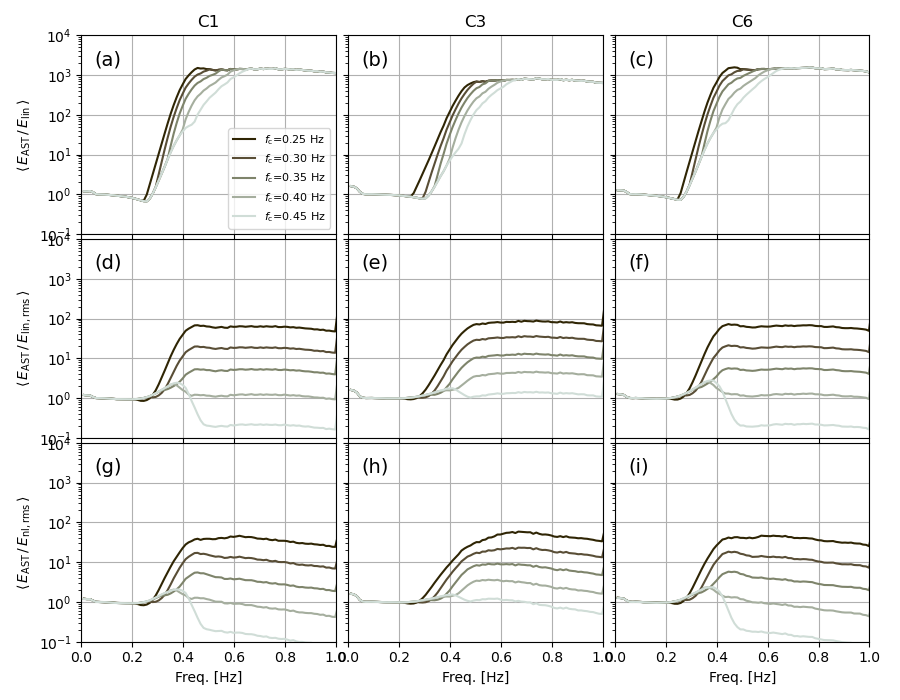

In [3]:
mids = ['C1', 'C3', 'C6'] # Mooring IDs
sers = ['103088', '103094', '103110'] # Serial numbers
tail_method = 'constant' # K_rms reconstruction tail method
lss = ['-', '--', ':'] # Linestyles for fc values in plots

# Initialize figure
fig, axes = plt.subplots(figsize=(9,7), nrows=3, ncols=3, sharex=True, sharey=True)
# Iterate over mooring IDs and serial numbers
for i, (mid, ser) in enumerate(zip(mids, sers)):
    # Initialize dicts to save diff. spectra
    d_lin = {'fc-0.25': [], 'fc-0.3': [], 'fc-0.35': [], 'fc-0.4': [], 'fc-0.45': []} # Linear
    d_link = {'fc-0.25': [], 'fc-0.3': [], 'fc-0.35': [], 'fc-0.4': [], 'fc-0.45': []} # Lin. K_rms
    d_nlk = {'fc-0.25': [], 'fc-0.3': [], 'fc-0.35': [], 'fc-0.4': [], 'fc-0.45': []} # Nonlin. K_rms
    # Signature velocity netcdf directory
    veldir = os.path.join(data_root, '{}'.format(ser)) 
    csvdir = os.path.join(veldir, 'p2eta')
    # Directory for spectral netcdf file
    ncdir = os.path.join(csvdir, 'spectra')
    # List all netcdf files
    fns_nc = sorted(glob.glob(os.path.join(ncdir, 'p2eta_spec*.nc')))
    # Iterate over spectral files
    for fn in fns_nc:
        # Read spectrum netcdf file
        dss = xr.open_dataset(fn)
        # Compute difference between AST and reconstructed spectra at different cutoffs
        for fc in [0.25, 0.3, 0.35, 0.4, 0.45]:
            # Linear reconstructions
            dss['Eld-{}'.format(fc)] = (['freq'], (dss['East'].values/dss['El-{}'.format(fc)].values))
            d_lin['fc-{}'.format(fc)].append(dss['Eld-{}'.format(fc)])
            dss['Elkd-{}'.format(fc)] = (['freq'], (dss['East'].values/dss['Elk-{}'.format(fc)].values))
            d_link['fc-{}'.format(fc)].append(dss['Elkd-{}'.format(fc)])
            dss['Enkd-{}'.format(fc)] = (['freq'], (dss['East'].values/dss['Enk-{}'.format(fc)].values))
            d_nlk['fc-{}'.format(fc)].append(dss['Enkd-{}'.format(fc)])
    # Concatenate spectra and plot mean diff and spread
    cs = ['#2F2504', '#594E36', '#7E846B', '#A5AE9E', '#D0DDD7']
    lw = 1.5 # Mean linewidth
    for fi, fc in enumerate([0.25, 0.3, 0.35, 0.4, 0.45]):
        # Linear 
        dsl = xr.concat(d_lin['fc-{}'.format(fc)], dim='time')
        # Mean diff. lin
        dsl.mean(dim='time').plot(ax=axes[0,i], color=cs[fi], linestyle='-', linewidth=lw,
                                  label=r'$f_\mathrm{c}$='+'{:.2f} Hz'.format(fc))
        # Linear K_rms
        dslk = xr.concat(d_link['fc-{}'.format(fc)], dim='time')
        # Mean diff. lin-K_rms
        dslk.mean(dim='time').plot(ax=axes[1,i], color=cs[fi], linestyle='-', linewidth=lw,
                                   )# label=r'$f_\mathrm{c}$='+'{}'.format(fc))
        # Nonlinear K_rms
        dsnk = xr.concat(d_nlk['fc-{}'.format(fc)], dim='time')
        # Mean diff. nl-K_rms
        dsnk.mean(dim='time').plot(ax=axes[2,i], color=cs[fi], linestyle='-', linewidth=lw,
                                   )# label=r'$f_\mathrm{c}$='+'{}'.format(fc))
    axes[0,i].set_title(mid)

ann = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
for a, ax in enumerate(axes.flat):
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xlim([0, 1])
    ax.set_ylim([1e-1, 1e4])
    ax.set_yscale('log')
    ax.grid()
    ax.annotate(ann[a], xy=(0.05,0.85), xycoords='axes fraction', fontsize=14)

axes[0,0].legend(loc='lower right', fontsize=8)
axes[2,0].set_xlabel('Freq. [Hz]')
axes[2,1].set_xlabel('Freq. [Hz]')
axes[2,2].set_xlabel('Freq. [Hz]')
axes[0,0].set_ylabel(r'$\langle \, E_\mathrm{AST} \, / \, E_\mathrm{lin} \, \rangle$')
axes[1,0].set_ylabel(r'$\langle \, E_\mathrm{AST} \, / \, E_\mathrm{lin, rms} \, \rangle$')
axes[2,0].set_ylabel(r'$\langle \, E_\mathrm{AST} \, / \, E_\mathrm{nl, rms} \, \rangle$')

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.025)
plt.show()


Compare zero-crossing wave/crest heights from AST against reconstructions.

Mooring ID:  C1


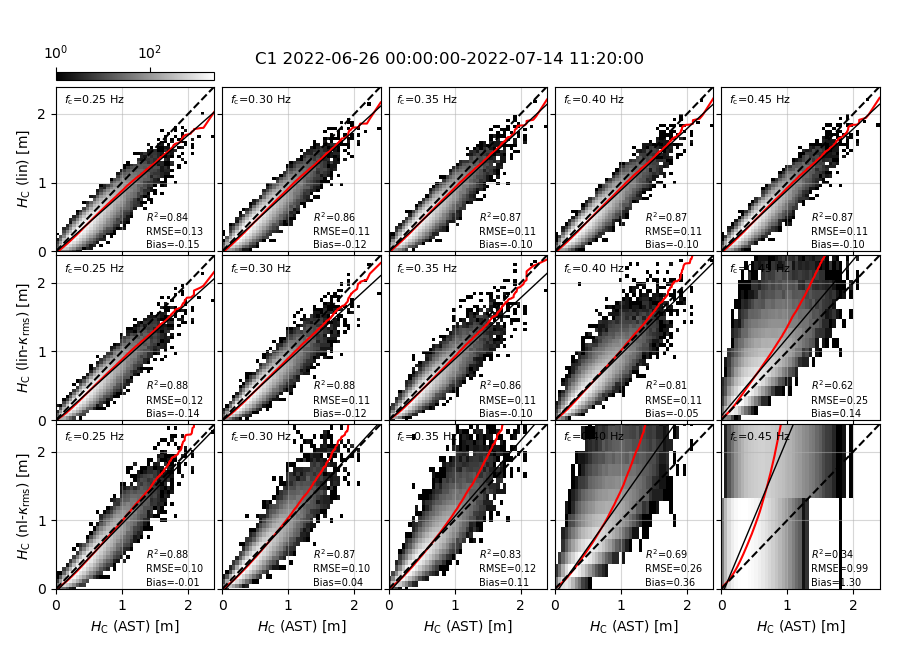

In [3]:
mids = ['C1', 'C3', 'C6'] # Mooring IDs
sers = ['103088', '103094', '103110'] # Serial numbers
tail_method = 'constant' # K_rms reconstruction tail method
fcs = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5] # High-frequency cutoffs
prs = ['etal', 'etalk', 'etank'] # Reconstruction products
hstr = 'crestheight' # String for either 'waveheight' or 'crestheight'
mstr = 'C1' # Mooring ID to plot

# Initialize figure
fig, axes = plt.subplots(figsize=(9,6.5), nrows=3, ncols=5, sharex=True, sharey=True)
# Iterate over mooring IDs and find all timeseries-reconstruction csv files
for i, (mid, ser) in enumerate(zip(mids, sers)):
    if not mid == mstr:
        continue
    print('Mooring ID: ', mid)
    # Initialize dicts for wave and crest heights
    Hws = {'H-{}-{}'.format(pr, fc): [] for pr in prs for fc in fcs}
    # Add hyd & ast
    Hws['H-hyd'] = []
    Hws['H-ast'] = []
    Hcs = {'C-{}-{}'.format(pr, fc): [] for pr in prs for fc in fcs}
    # Add hyd & ast
    Hcs['C-hyd'] = []
    Hcs['C-ast'] = []
    timestamps = [] # List to store timestamps for dataframe index
    # Signature velocity netcdf directory
    veldir = os.path.join(data_root, '{}'.format(ser)) 
    csvdir = os.path.join(veldir, 'p2eta')
    # Define output dir. for csv files
    zcdir = os.path.join(csvdir, 'zero_crossings')
    # .csv filename
    fn_csv = os.path.join(zcdir, 'p2eta_{}_{}_{}.csv'.format(mid, ser, hstr))
    # Read csv
    dfz = pd.read_csv(fn_csv, parse_dates=['time']).set_index('time')
    # Plot scatter plots of each reconstruction against AST
    if hstr == 'crestheight':
        s = 'C'
    elif hstr == 'waveheight':
        s = 'H'
    x = dfz['{}-ast'.format(s)].values # x axis is always AST
    ims = [] # List to store images
    for pi, pr in enumerate(prs):
        for fi, fc in enumerate(fcs[:-1]):
            # Get y axis
            y = dfz['{}-{}-{}'.format(s, pr, fc)].values
            # Use 2D histogram for scatter plot
            _, _, _, im = axes[pi,fi].hist2d(x, y, norm=colors.LogNorm(), cmap=mpl.cm.gray, 
                                             bins=[50,50])
            # Save image to list
            ims.append(im)
            # Quantile-quantile plot
            rppl.qqplot(x, y, ax=axes[pi,fi], scatter=False, color='r')
            # Linear regression
            res = linregress(x, y)
            rmse = mean_squared_error(x, y, squared=False)
            xp = np.linspace(0, x.max())
            # Linear regression line
            axes[pi,fi].plot(xp, res.intercept + res.slope*xp, color='k', linewidth=1)
            # One-to-one line
            axes[pi,fi].plot(xp, xp, color='k', linestyle='--')
            # Annotate regression statistics
            rsq = r'$R^2$={:.2f}'.format(res.rvalue**2)
            fsz = 7
            axes[pi,fi].annotate(rsq, xy=(0.57, 0.18), xycoords="axes fraction", fontsize=fsz)
            rmsestr = 'RMSE={:.2f}'.format(rmse)
            axes[pi,fi].annotate(rmsestr, xy=(0.57, 0.1), xycoords="axes fraction", fontsize=fsz)
            bias = 'Bias={:.2f}'.format(res.slope - 1)
            axes[pi,fi].annotate(bias, xy=(0.57, 0.02), xycoords="axes fraction", fontsize=fsz)
            # Also annotate cutoff frequency
            axes[pi,fi].annotate(r'$f_\mathrm{c}$='+'{:.2f} Hz'.format(fc), xy=(0.05, 0.9), 
                xycoords="axes fraction", fontsize=fsz+1)
# Colorbar on upper left subplot
cax = axes[0,0].inset_axes([0.0, 1.04, 1, 0.05], transform=axes[0,0].transAxes)
cbar = fig.colorbar(ims[0], ax=axes[0,0], cax=cax, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
# Common axis parameters
for ax in axes.flat:
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xlim([0, x.max()])
    ax.set_ylim([0, x.max()])
    ax.locator_params(axis='both', nbins=4)
    ax.grid(alpha=0.5)
# Axis labels
for ax in axes[-1,:]:
    ax.set_xlabel(r'$H_\mathrm{C}$ (AST) [m]')
axes[0,0].set_ylabel(r'$H_\mathrm{C}$ (lin) [m]')
axes[1,0].set_ylabel(r'$H_\mathrm{C}$ (lin-$\kappa_\mathrm{rms}$) [m]')
axes[2,0].set_ylabel(r'$H_\mathrm{C}$ (nl-$\kappa_\mathrm{rms}$) [m]')
# Save/show figure
plt.suptitle('{} {}-{}'.format(mstr, str(dfz.index[0].floor('20T')), str(dfz.index[-1].ceil('20T'))),
    y=0.92)
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.025)
plt.show()


In [9]:
plt.clf()